## Analyse des échantillons


### Nombre d’échantillons

#### Nombre de polygones par classe

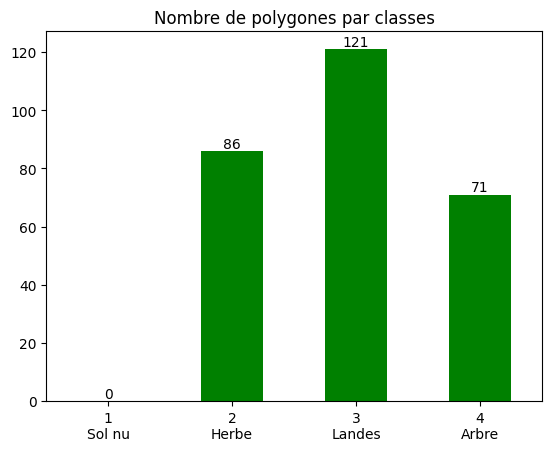

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

shp_path = os.path.join(
    "data",
    "projet_eval",
    "PI_strates_bretagne_32630.shp"
)

echantillon_shp = gpd.read_file(shp_path)

# Dictionnaire de référence car la liste des classes est connue et prévisible
labels_strates = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

# Compter et forcer les strates attendues
counts = (
    echantillon_shp["strate"]
    .value_counts()
    .reindex(labels_strates.keys())
    .fillna(0)
)

fig, ax = plt.subplots()
counts.plot(kind="bar", ax=ax, color="green")

# Affiche les valeurs
for i, val in enumerate(counts):
    ax.text(i, val, int(val), ha="center", va="bottom") 

# Labels de l'axe X depuis le dictionnaire
ax.set_xticklabels([f"{s}\n{labels_strates[s]}" for s in counts.index], rotation=0)

# Titres graphique et axes
ax.set_title("Nombre de polygones par classes")
plt.xlabel('')
plt.ylabel('')

# Sortie
output_dir = os.path.join("results", "figure")

os.makedirs(output_dir,exist_ok=True) # Crée le dossier s'il n'existe pas

output_path = os.path.join(output_dir, "diag_baton_nb_poly_by_class.png")

plt.savefig(output_path)

plt.show()

On remarque que les landes sont la classe majoritaire parmi les polygones servant d'échantillons, viennent ensuite l'herbe et les arbres.

En revanche, **aucun polygone n'est classé en sol nu**. Cela pourra poser des problèmes plus tard, notamment lors de la classification supervisée, en créant des **biais**. En effet, sans échantillon de référence dans cette classe, les modèles vont probablement avoir du mal à apprendre puis reconnaître ce qui correspond effectivement à du sol nu.

#### Nombre de pixels par classe

On vérifie d'abord si tous les fichiers de travail (les 11 bandes + le .shp d'échantillons) sont bien projetés dans le **même CRS**.

In [14]:
from my_function import verif_crs

raster_dir = os.path.join("data","projet_eval")
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
shp_path = os.path.join("data","projet_eval","PI_strates_bretagne_32630.shp")

result = verif_crs(raster_dir, bands, shp_path)
print(result)

✅ Tous les CRS sont identiques (EPSG:32630)


Puis que les bandes ont la **même résolution spatiale** (taille des pixels) et la **même dimension** (nombre de colonnes $\times$ nombre de lignes).

In [ ]:
from my_function import verif_rasters_geom

raster_dir = "data/projet_eval"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]

result = verif_rasters_geom(raster_dir, bands)
print(result)

✅ Toutes les bandes ont la même taille de pixel (10.0, 10.0) et les mêmes dimensions (1533, 612)


Pour cette partie, on peut utiliser une seule bande comme support raster, car le nombre de pixels par classe dépend uniquement des **propriétés géométriques** des bandes.
Comme nous avons vérifié que chaque bande est identique, on peut utiliser **n'importe laquelle** d'entre elles. 

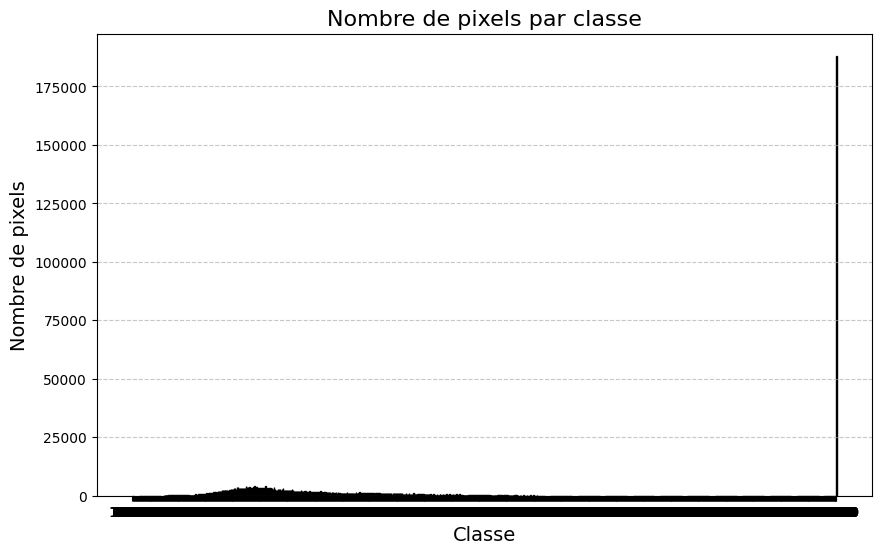

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from libsigma.classification import get_samples_from_roi
from libsigma.read_and_write import load_img_as_array

# ======= Paramètres à modifier =======
raster_file = os.path.join("data","projet_eval","bretagne_24-25_B02.tif")
roi_file = None  # ou "path/to/ton_roi.tif" si tu veux limiter au ROI
value_to_extract = None  # optionnel : liste des valeurs à compter
out_filename = None  # optionnel : chemin pour sauvegarder le graphique

# ======= Chargement des données =======
if roi_file:
    # Extraction des pixels correspondant au ROI
    X, Y, _ = get_samples_from_roi(raster_file, roi_file,
                                   value_to_extract=value_to_extract)
    array_to_count = Y.flatten()
else:
    # Chargement du raster complet
    array = load_img_as_array(raster_file)
    if array.shape[2] > 1:
        # Si plusieurs bandes, on analyse uniquement la première
        array_to_count = array[:, :, 0].flatten()
    else:
        array_to_count = array.flatten()
    if value_to_extract is not None:
        mask = np.isin(array_to_count, value_to_extract)
        array_to_count = array_to_count[mask]

# ======= Comptage des pixels par classe =======
classes, counts = np.unique(array_to_count, return_counts=True)

# ======= Création du diagramme en bâtons =======
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(classes.astype(str), counts, color='cornflowerblue', edgecolor='k')

# ======= Personnalisation graphique =======
ax.set_xlabel('Classe', fontsize=14)
ax.set_ylabel('Nombre de pixels', fontsize=14)
ax.set_title('Nombre de pixels par classe', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# ======= Affichage ou sauvegarde =======
if out_filename:
    plt.savefig(out_filename, bbox_inches='tight', dpi=300)
plt.show()


### Phénologie des strates, mise en évidence des landes

## Production d'une carte de strates à l'échelle du pixel

### Choix du classifieur et sa paramétrisation

### Stratégie de validation

### Contribution des variables

### Production des cartes finales

### Analyse des résultats